In [ ]:
library(data.table)
library(glue)
library(dplyr)
library(plotly)
library(ggplot2)
library(grid)
library(gridExtra)

options(scipen=999)

In [ ]:
#Download PanelApp data
#install.packages("rvest")
library(rvest)
panels <- read_html("https://panelapp.genomicsengland.co.uk/panels/")
panels2 <- panels %>%html_nodes("h4")
allPanelsList <- (lapply(panels2[-length(panels2)], function(panel){
    panelURL <- paste0("https://panelapp.genomicsengland.co.uk",panel%>% html_nodes("a") %>%  html_attr("href") ,"download/01234/")
    print(panelURL)
    fread(panelURL)
}))
allPanelsDT <- rbindlist(allPanelsList)
idx <- grep ("Expert Review Green", allPanelsDT$"Sources(; separated)" )
allPanelsDT2 <- allPanelsDT[idx,]
allPanelsDT3 <- allPanelsDT2[grep("BIALLELIC", allPanelsDT2$Model_Of_Inheritance),]

In [2]:
# Read input VCF
tgp_vcf <- fread("/home/matdawidziuk/tgp_pl/multisample_20210519.dv.bcfnorm.filtered.nogt.vcf.gz", skip="#CHROM", sep="\t")

In [ ]:
# Check dim
dim(tgp_vcf)
head(tgp_vcf)

In [4]:
# Read TGP vep annotated file
tgp_vep <- fread("/data/NGS/annotations/test_design/pl_genomes/run_1/output/multisample_20210519.dv.bcfnorm.filtered.nogt.header.format.dummygt_VEP.tsv", sep="\t")

In [ ]:
# Check dim
dim(tgp_vep)
head(tgp_vep)

In [6]:
#  Split INFO
tgp_vcf[, c("AF", "AQ", "AN", "AC") := tstrsplit(INFO, ";", fixed=TRUE)]

In [7]:
# Clean new columns, remove AQ (duplicates QUAL)
tgp_vcf[, AF := gsub("[^0-9.-]", "", AF)][, AN := gsub("[^0-9.-]", "", AN)][, AC := gsub("[^0-9.-]", "", AC)][, AQ := NULL]

In [ ]:
head(tgp_vcf)

In [9]:
# Create key - further used to merge with VCF file
tgp_vep[, key2 := gsub(">", "_", gsub(":", "_", key))]
setkey(tgp_vep, key2)
setkey(tgp_vcf, ID)

In [ ]:
# Copy selected columns from VCF to TSV
selected_columns <- c("REF", "ALT", "QUAL", "AF", "AN", "AC")
tgp_vep[tgp_vcf, (selected_columns) := mget(paste0('i.', selected_columns))]
head(tgp_vep)

In [13]:
# Conseuqneces summary
csq_table <- as.data.table(table(tgp_vep$Consequence))
head(csq_table)

V1,N
3_prime_UTR_variant,338919
"3_prime_UTR_variant,NMD_transcript_variant",2567
5_prime_UTR_variant,57559
"5_prime_UTR_variant,NMD_transcript_variant",162
coding_sequence_variant,8
"coding_sequence_variant,3_prime_UTR_variant",1


In [14]:
# Select "main" consequence per each row 
csq_table$csq_first <- sapply(strsplit(csq_table$V1, ","), `[`, 1)
csq_first <- as.data.table(csq_table %>% mutate(csq_first = toupper(csq_first)) %>% 
    group_by(csq_first) %>% summarise(N = sum(N)))
dim(csq_first)
head(csq_first)

[1] 24  2

csq_first,N
3_PRIME_UTR_VARIANT,341486
5_PRIME_UTR_VARIANT,57721
CODING_SEQUENCE_VARIANT,9
DOWNSTREAM_GENE_VARIANT,2131350
FRAMESHIFT_VARIANT,4416
INCOMPLETE_TERMINAL_CODON_VARIANT,4


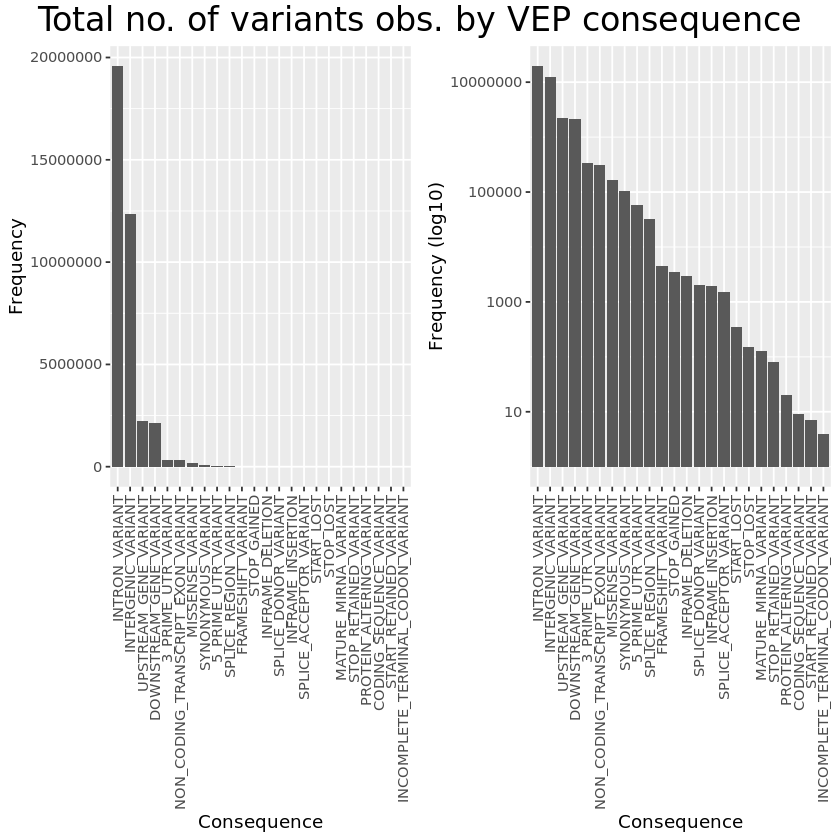

In [15]:
# Plot consequences
p1 <- ggplot(csq_first, aes(reorder(csq_first, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    scale_y_log10() +
    labs(x = "Consequence", y = "Frequency (log10)")
p2 <- ggplot(csq_first, aes(reorder(csq_first, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    labs(x = "Consequence", y = "Frequency")
    #theme(plot.title = "Liczba wariantów dla poszczególnych głownych konsekwencji", axis.title.x = element_blank(), axis.title.y = element_blank())


grid.arrange(p2, p1, nrow = 1, top = textGrob("Total no. of variants obs. by VEP consequence",gp=gpar(fontsize=20)))

In [29]:
# Read AR genes from OMIM
omim_recessive <- fread("/srv/data/TGP-notebooks/recessive_genes.bed", sep="\t", col.names=c("chr", "start", "end", "symbol"))
omim_recessive <- unique(omim_recessive, by = "symbol")

In [176]:
# Recessive clinvar pathogenic/likely pathogenic variants
clinvar_recessive <- tgp_vep[which(Symbol %in% omim_recessive$symbol & CLNSIG %in% c("Pathogenic", "Pathogenic/Likely_pathogenic", "Likely_pathogenic)"))]

In [142]:
dim(tgp_vep[which(AC==0)])

[1] 429163    154

In [ ]:
# 10 variants with AC=0
dim(clinvar_recessive)
dim(clinvar_recessive[which(AC>0)])
head(clinvar_recessive[which(AC==0)])

In [150]:
table(clinvar_recessive[,Consequence])


                                        5_prime_UTR_variant 
                                                          3 
                                    downstream_gene_variant 
                                                         12 
                                         frameshift_variant 
                                                        118 
                   frameshift_variant,splice_region_variant 
                                                          3 
                                           inframe_deletion 
                                                          6 
                                          inframe_insertion 
                                                          1 
                                             intron_variant 
                                                         18 
                                           missense_variant 
                                                        251 
                     mi

In [177]:
clinvar_recessive[which(Consequence == "upstream_gene_variant"),ClinVar_url]

[1] "https://www.ncbi.nlm.nih.gov/clinvar/variation/12076/" 
 [2] "https://www.ncbi.nlm.nih.gov/clinvar/variation/265135/"
 [3] "https://www.ncbi.nlm.nih.gov/clinvar/variation/626999/"
 [4] "https://www.ncbi.nlm.nih.gov/clinvar/variation/116/"   
 [5] "https://www.ncbi.nlm.nih.gov/clinvar/variation/188834/"
 [6] "https://www.ncbi.nlm.nih.gov/clinvar/variation/573257/"
 [7] "https://www.ncbi.nlm.nih.gov/clinvar/variation/162203/"
 [8] "https://www.ncbi.nlm.nih.gov/clinvar/variation/223044/"
 [9] "https://www.ncbi.nlm.nih.gov/clinvar/variation/16663/" 
[10] "https://www.ncbi.nlm.nih.gov/clinvar/variation/223019/"
[11] "https://www.ncbi.nlm.nih.gov/clinvar/variation/31077/"

In [ ]:
dim(clinvar_recessive[which(AF > gnomAD_AF_NFE), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF")])
head(clinvar_recessive[which(AF > gnomAD_AF_NFE), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF")])

In [179]:
clinvar_gene_table <- as.data.table(sort(table(clinvar_recessive$Symbol), decreasing = TRUE))

In [180]:
head(clinvar_gene_table)
dim(clinvar_gene_table)

V1,N
ABCA4,9
PAH,9
ACADM,5
USH2A,5
ALDOB,4
ANO5,4


[1] 432   2

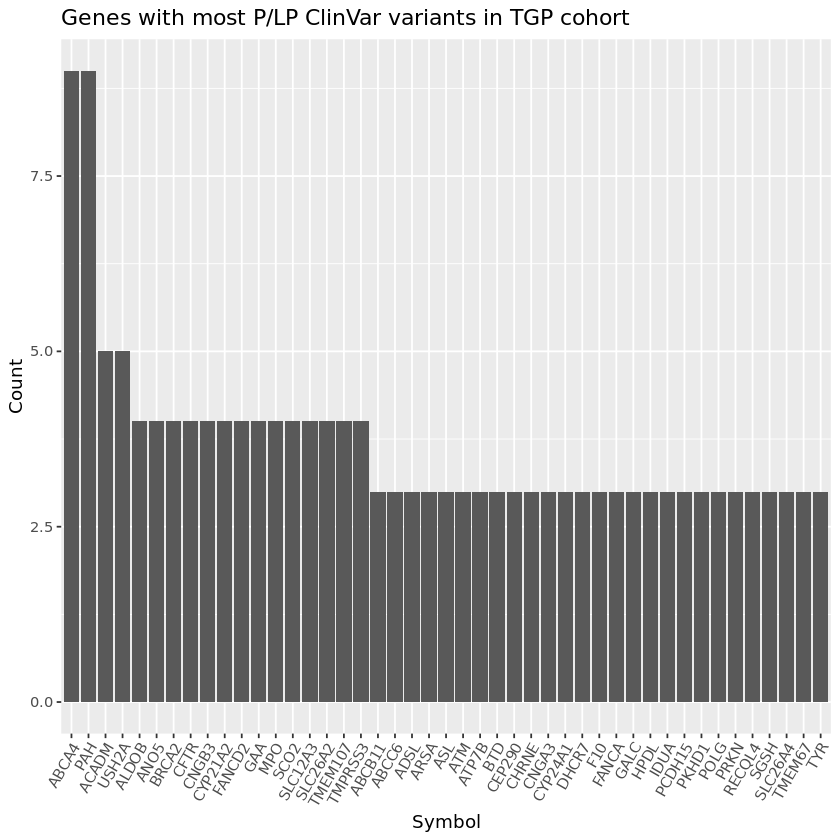

In [182]:
# Genes with the highest number of Clinvar pathogenic varianst
clinvar_gene_table_2 <- clinvar_gene_table[which(N > 2)]
ggplot(clinvar_gene_table[which(N > 2)], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 60)) +
    labs(title = "Genes with most P/LP ClinVar variants in TGP cohort", x = "Symbol", y = "Count")

In [184]:
clinvar_recessive$AF <- as.numeric(clinvar_recessive$AF)

In [185]:
melt_clinvar <- melt(clinvar_recessive, id.vars = c("key2"), measure.vars = c("gnomAD_AF", "gnomAD_AF_NFE", "AF"), variable.name = c("database"), value.name = c("frequency"))

In [187]:
dim(melt_clinvar)
#head(melt_clinvar)

[1] 1944    3

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_boxplot).”

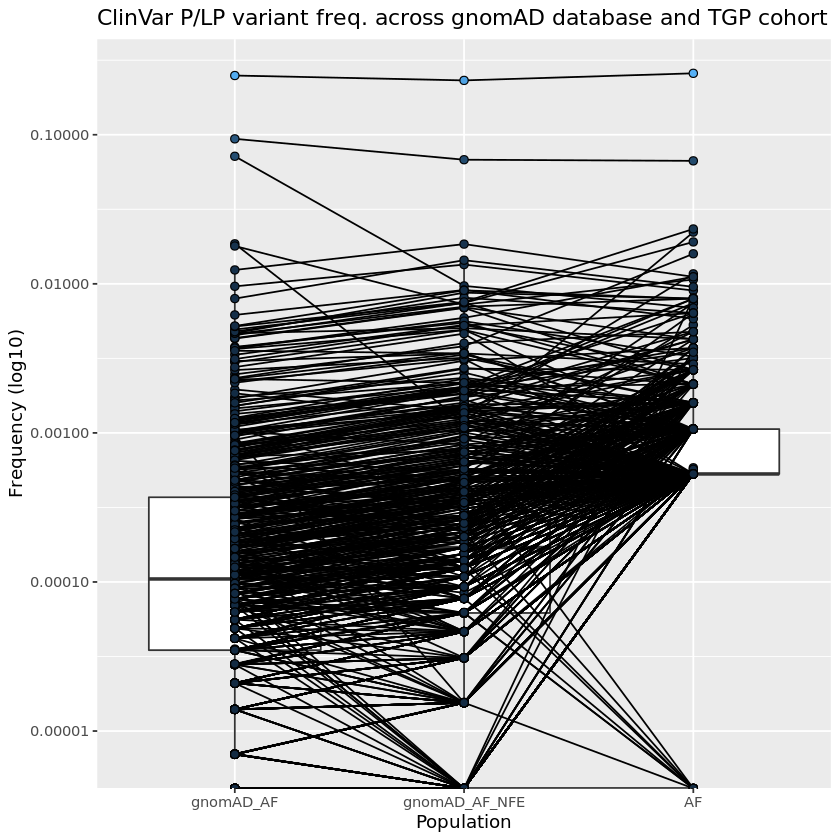

In [188]:
ggplot(melt_clinvar, aes(database,frequency, fill=frequency)) +
    geom_boxplot() +
    geom_line(aes(group=key2)) +
    geom_point(aes(fill=frequency,group=database),size=2,shape=21, position = position_dodge(0.2)) +
    theme(legend.position = "none") +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

In [191]:
clinvar_recessive_overrep_TGP <- clinvar_recessive[which(AF > gnomAD_AF_NFE & AF > gnomAD_AF), c("key2","gnomAD_AF","gnomAD_AF_NFE", "AF")]
#head(clinvar_recessive_overrep_TGP)
melt_clinvar_overrep_TGP <- melt(clinvar_recessive_overrep_TGP, id.vars = c("key2"), measure.vars = c("gnomAD_AF", "gnomAD_AF_NFE", "AF"), variable.name = c("database"), value.name = c("frequency"))
#head(melt_clinvar_overrep_TGP)

In [192]:
clinvar_recessive_diff <- clinvar_recessive[, diff_AF := gnomAD_AF - AF][, diff_AF_NFE := gnomAD_AF_NFE - AF]

In [194]:
#head(clinvar_recessive_diff[which(diff_AF < 0 & diff_AF_NFE < 0), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF", "diff_AF", "diff_AF_NFE")])
dim(clinvar_recessive_diff[which(diff_AF < 0 & diff_AF_NFE < 0)])

[1] 551 156

In [196]:
#ggplot(clinvar_recessive_overrep_TGP, aes(database, frequency, fill = frequency)) +
#    geom_boxplot() +
#    geom_line(aes(group = key2)) +
#    geom_point(aes(fill = frequency, group = database), size = 2, shape = 21, position = position_dodge(0.2)) +
#    theme(legend.position = "none") +
#    scale_y_log10() +
#    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

#ggplot(clinvar_recessive_overrep_TGP, aes(x=database, y=frequency)) +
#    geom_boxplot() +
#    geom_jitter(colour="lightblue", height = 0) +
#    scale_y_log10() +
#    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 211 rows containing missing values (geom_point).”

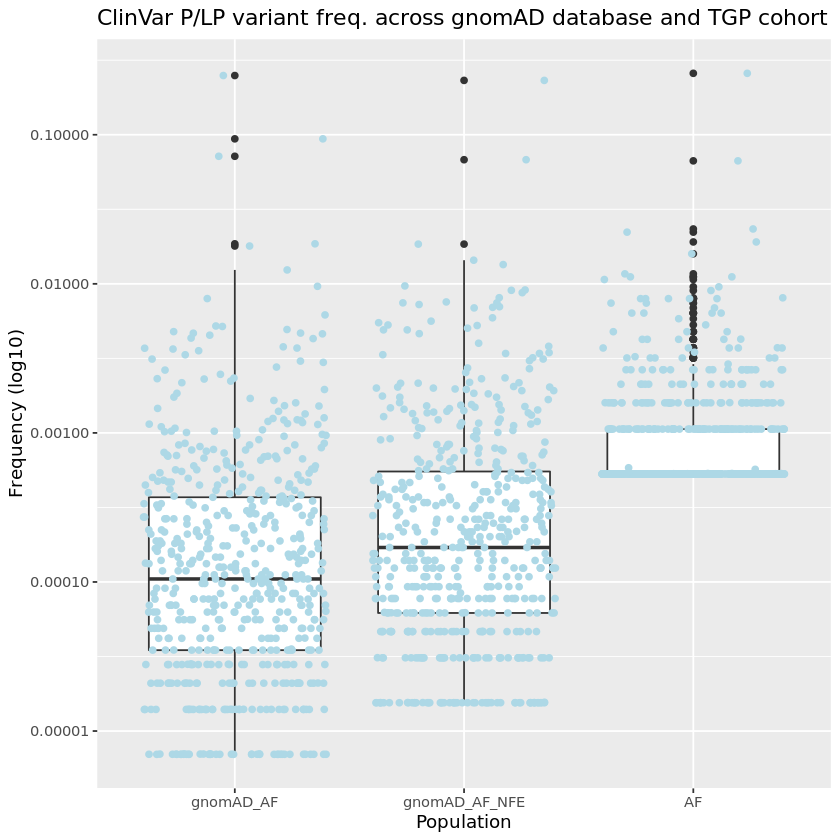

In [197]:
ggplot(melt_clinvar, aes(x=database, y=frequency)) +
    geom_boxplot() +
    geom_jitter(colour="lightblue", height = 0) +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 211 rows containing non-finite values (stat_sum).”

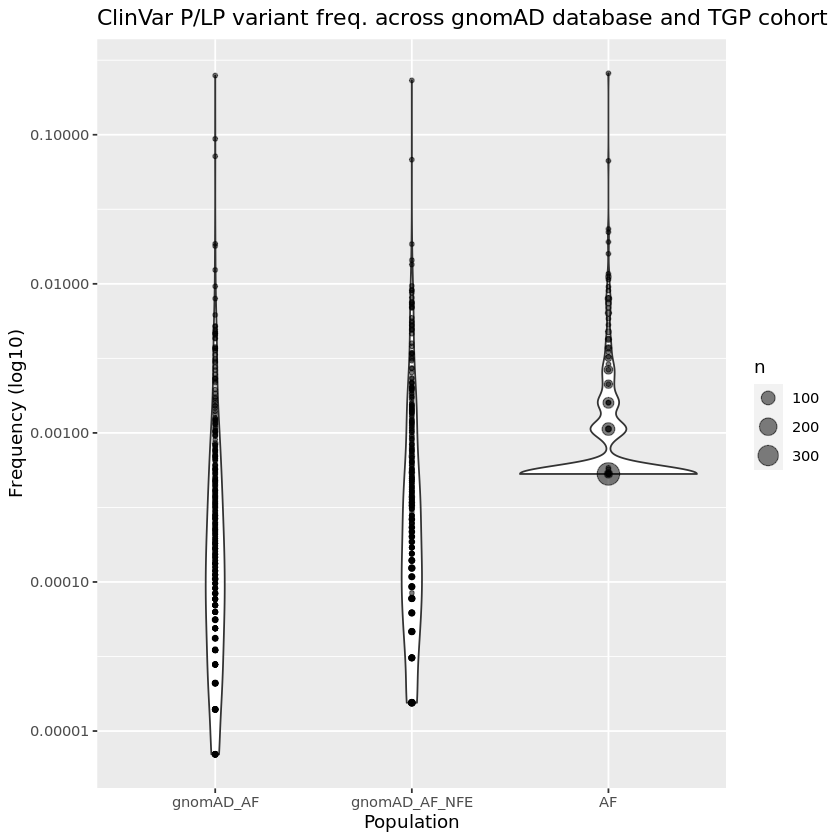

In [198]:
ggplot(melt_clinvar, aes(x=database, y=frequency)) +
    geom_violin() +
    geom_count(alpha=0.5) +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

# Cumulative frequencies of rare with high or moderate impact potentially pathogenic variants in recessive disease genes

In [30]:
tgp_vep_nonsyn_rare <- tgp_vep[which(Symbol %in% omim_recessive$symbol & gnomAD_AF < 0.01 & AF < 0.01 & Impact %in% c("MODERATE", "HIGH"))]

In [156]:
tgp_vep_nonsyn_rare$panelApp <- NA
tgp_vep_nonsyn_rare$panelApp <- allPanelsDT3$Level4[match(tgp_vep_nonsyn_rare$Symbol, allPanelsDT3$"Gene Symbol")]

In [203]:
dim(tgp_vep_nonsyn_rare)
#head(tgp_vep_nonsyn_rare)

[1] 26124   161

In [167]:
get_cum_AF <- function(tgp_vep_nonsyn_rare, byCol="Symbol" ){
    tgp_vep_cum_gene_freq_AF <- tgp_vep_nonsyn_rare[, cum_AF := sum(as.numeric(AF)), by=byCol][, cum_gnomadAF := sum(as.numeric(gnomAD_AF)), by=Symbol][, cum_gnomadAF_NFE := sum(as.numeric(gnomAD_AF_NFE)), by=byCol]
    tgp_vep_cum_gene_freq_AF <- tgp_vep_cum_gene_freq_AF[, cum_AF2 := cum_AF^2][, cum_gnomadAF2 := cum_gnomadAF^2][, cum_gnomadAF_NFE2 := cum_gnomadAF_NFE^2]
    tgp_vep_cum_gene_freq_AF_unique <- tgp_vep_cum_gene_freq_AF[-which(duplicated(tgp_vep_cum_gene_freq_AF[,byCol,with=F])),]
    tgp_vep_cum_gene_freq_AF_unique[order(cum_AF2, decreasing =TRUE), c(byCol, "cum_AF", "cum_AF2", "cum_gnomadAF", "cum_gnomadAF2", "cum_gnomadAF_NFE", "cum_gnomadAF_NFE2", "panelApp"),with=F]
}
get_cum_panel <- function(data){
    data[,sumPanelApp_AF2:=sum(cum_AF2),by="panelApp"][,sum_gnomad_PanelApp_AF2:=sum(cum_gnomadAF2),by="panelApp"][,sum_gnomad_PanelApp_AF_NFE2:=sum(cum_gnomadAF_NFE2),by="panelApp"]
    data[-which(duplicated(panelApp)),]
}

In [168]:
clinvar_cumAF <- get_cum_AF(tgp_vep_nonsyn_rare[which(CLNSIG %in% c("Pathogenic", "Pathogenic/Likely_pathogenic", "Likely_pathogenic"))])
clinvar_panel_cumAF2 <- get_cum_panel(clinvar_cumAF)


In [211]:
CADD_cumAF <- get_cum_AF(tgp_vep_nonsyn_rare[which(CADD_phred > 20)])

Warning message:
“Removed 1 rows containing missing values (geom_text).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

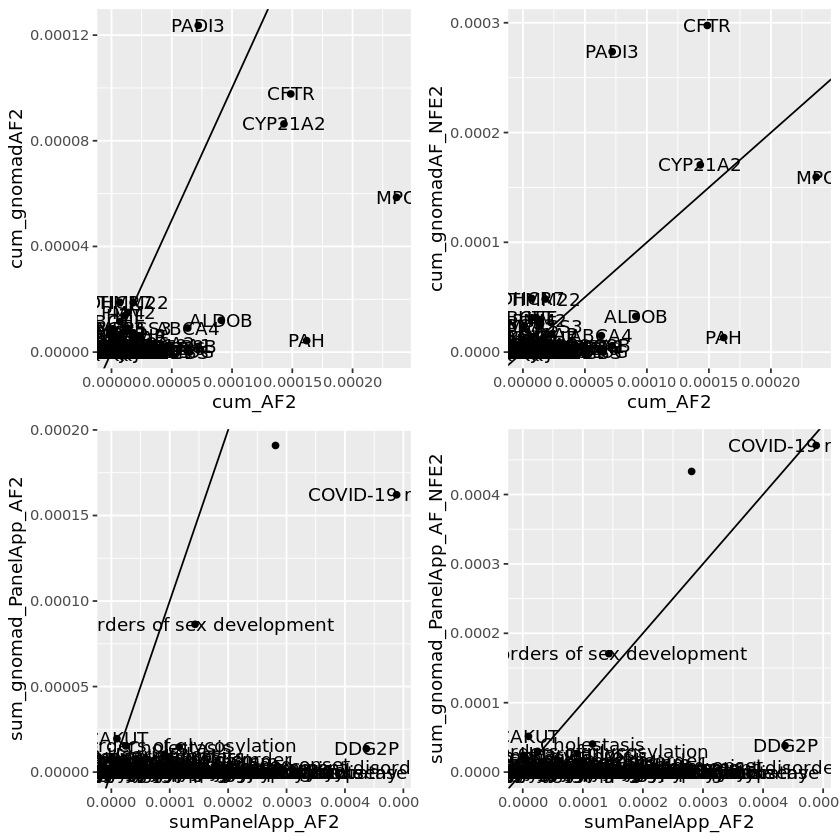

In [173]:
p1 <- ggplot(clinvar_cumAF, aes(cum_AF2, cum_gnomadAF2)) +
    geom_point() +
    geom_text(aes(label = Symbol)) + 
    geom_abline()
p2 <- ggplot(clinvar_cumAF, aes(cum_AF2, cum_gnomadAF_NFE2)) +
    geom_point() +
    geom_text(aes(label = Symbol)) + 
    geom_abline()
p3 <- ggplot(clinvar_panel_cumAF2, aes(sumPanelApp_AF2, sum_gnomad_PanelApp_AF2)) +
    geom_point() +
    geom_text(aes(label = panelApp)) + 
    geom_abline()
p4 <- ggplot(clinvar_panel_cumAF2, aes(sumPanelApp_AF2, sum_gnomad_PanelApp_AF_NFE2)) +
    geom_point() +
    geom_text(aes(label = panelApp)) + 
    geom_abline()

grid.arrange(p1, p2, p3,p4 ,nrow = 2)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

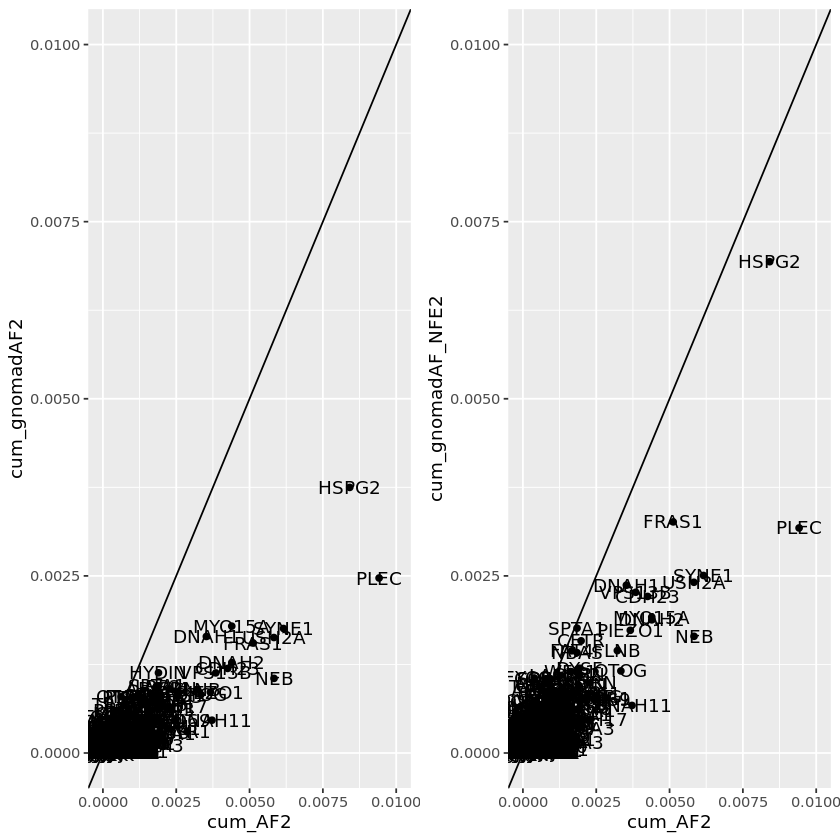

In [212]:
p1 <- ggplot(CADD_cumAF, aes(cum_AF2, cum_gnomadAF2)) +
    geom_point() +
    geom_text(aes(label = Symbol)) + 
    geom_abline() +
    ylim(0, 0.01) +
    xlim(0, 0.01) 
    #scale_x_log10() +
    #scale_y_log10()
p2 <- ggplot(CADD_cumAF, aes(cum_AF2, cum_gnomadAF_NFE2)) +
    geom_point() +
    geom_text(aes(label = Symbol)) + 
    geom_abline() +
    ylim(0, 0.01) +
    xlim(0, 0.01) 
    #scale_x_log10() +
    #scale_y_log10()
grid.arrange(p1, p2, nrow = 1)

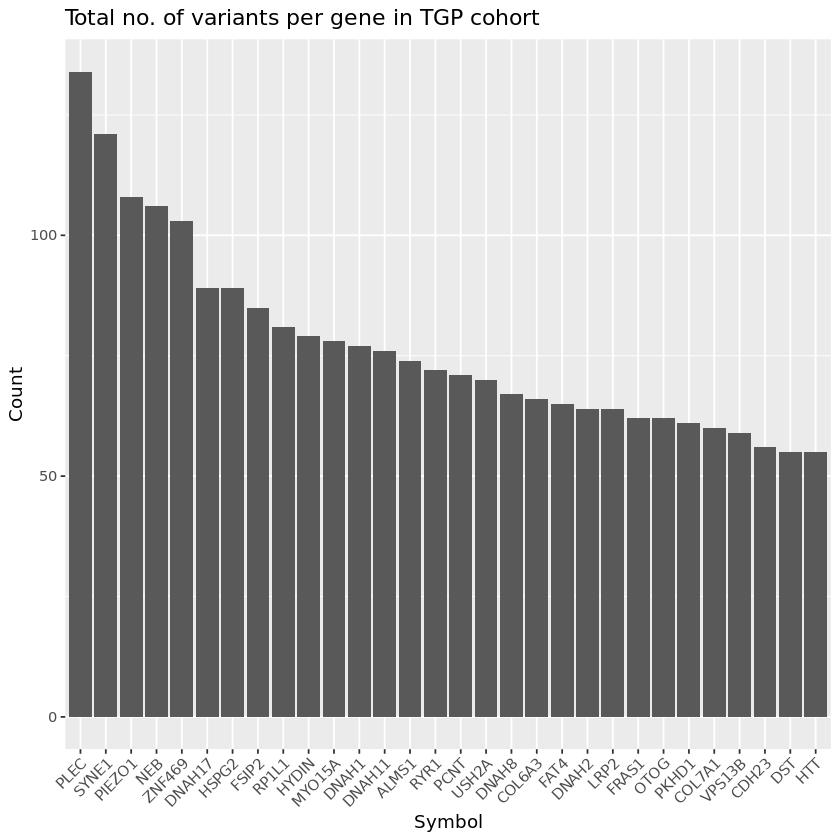

In [201]:
tgp_vep_gene_table <- as.data.table(sort(table(tgp_vep_nonsyn_rare$Symbol), decreasing = TRUE))
ggplot(tgp_vep_gene_table[2:31], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 45)) +
    labs(title = "Total no. of variants per gene in TGP cohort", x = "Symbol", y = "Count")

In [204]:
tgp_vep_gene_table_singleton <- as.data.table(sort(table(tgp_vep_nonsyn_rare[which(AF < 0.01 & AC == 1)]$Symbol), decreasing = TRUE))

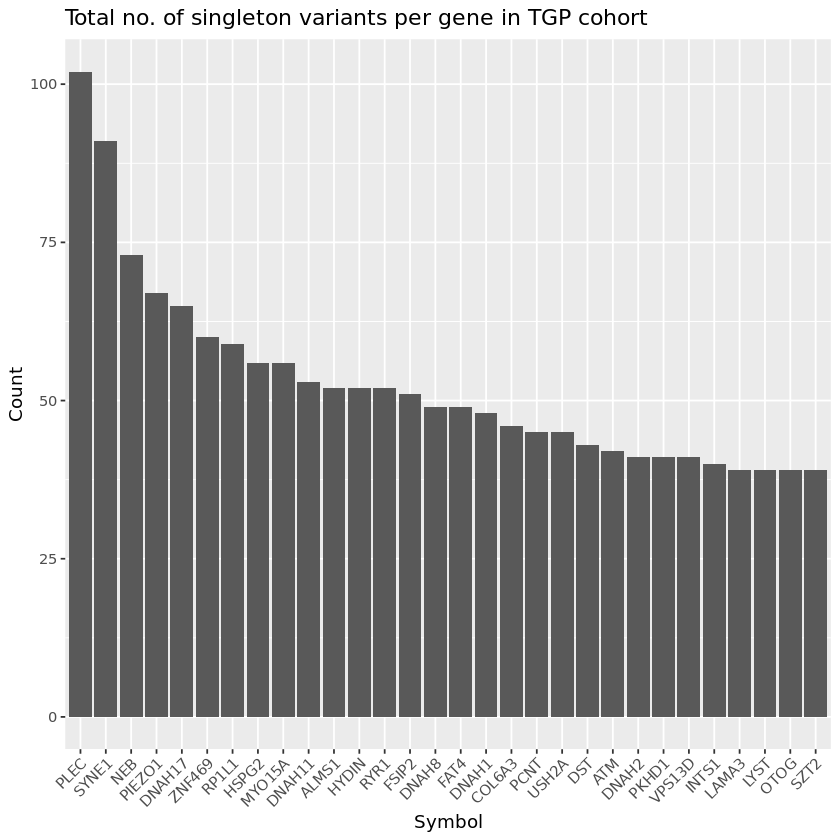

In [205]:
ggplot(tgp_vep_gene_table_singleton[2:31], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 45)) +
    labs(title = "Total no. of singleton variants per gene in TGP cohort", x = "Symbol", y = "Count")